In [5]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import random
import pandas as pd
from pylab import mpl, plt
mpl.rcParams['font.family'] = 'serif'

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

#verify that data exists in corredt directory
import os
for dirname, _, filenames in os.walk('data'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))

data/AAPL:US.csv


In [7]:
def stocks_data(symbols):
    dfs = []
    for symbol in symbols:
        df_temp = pd.read_csv(f"data/{symbol}:US.csv", parse_dates=['Date'], index_col='Date')
        df_temp = df_temp[['Close($)']].rename(columns={'Close($)': symbol})
        dfs.append(df_temp)
    return pd.concat(dfs, axis=1)

/var/folders/kk/542m2v2s2b15s19_tvdr4ghh0000gn/T/ipykernel_8504/4199266431.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_temp = pd.read_csv(f"data/{symbol}:US.csv", parse_dates=['Date'], index_col='Date')


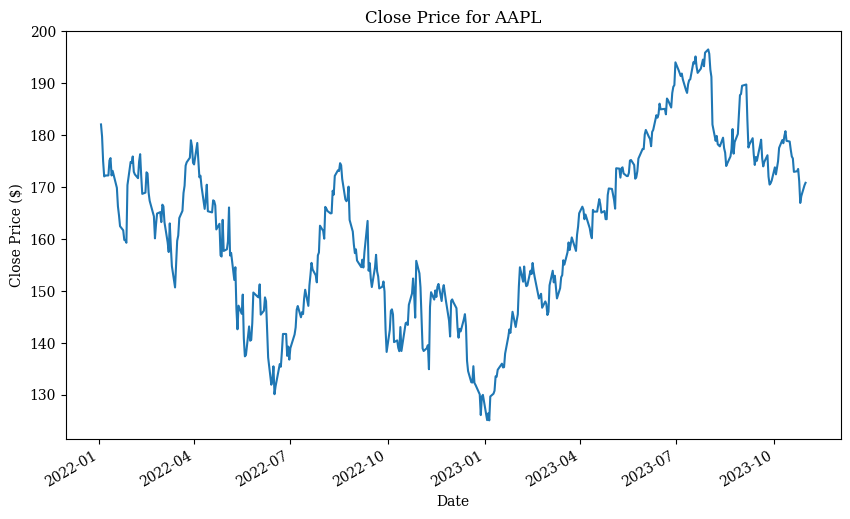

,AAPL
Date,
2023-10-31,170.77
2023-10-30,170.29
2023-10-27,168.22
2023-10-26,166.89
2023-10-25,171.10


In [8]:
symbols = ['AAPL']
df = stocks_data(symbols)

plt.figure(figsize=(10, 6))
df[symbols[0]].plot()
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.title(f'Close Price for {symbols[0]}')
plt.show()

df.head()

/var/folders/kk/542m2v2s2b15s19_tvdr4ghh0000gn/T/ipykernel_8504/3353113012.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_aapl=pd.read_csv("data/AAPL:US.csv", parse_dates=True, index_col=0)


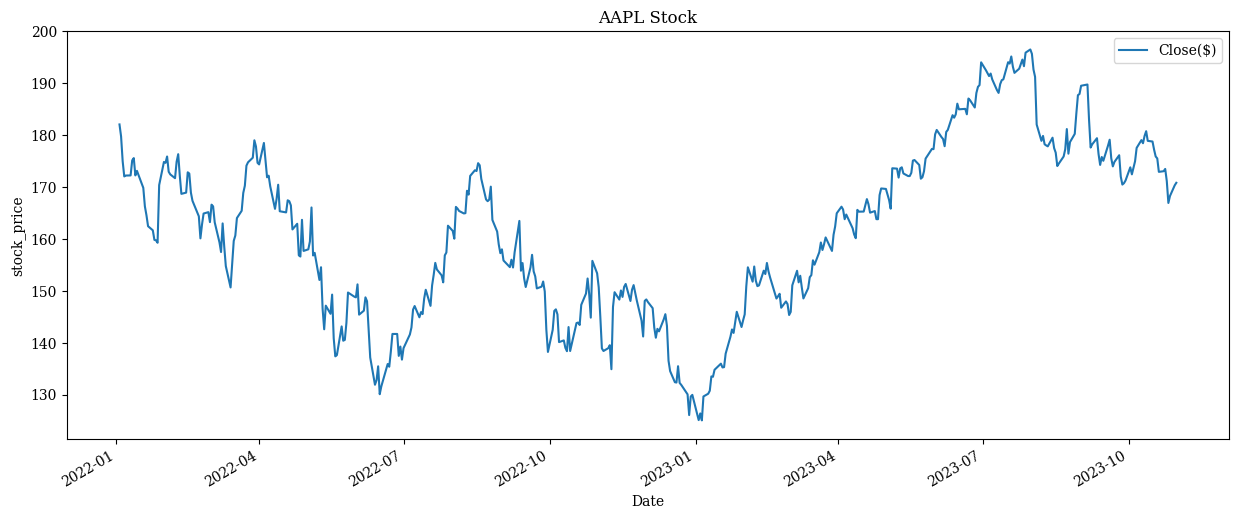

In [9]:
df_aapl=pd.read_csv("data/AAPL:US.csv", parse_dates=True, index_col=0)
df_aapl[['Close($)']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("AAPL Stock")
plt.show()

In [10]:
df_aapl = df_aapl[['Close($)']]
df_aapl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 460 entries, 2023-10-31 to 2022-01-03
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close($)  460 non-null    float64
dtypes: float64(1)
memory usage: 7.2 KB


In [11]:
df_aapl=df_aapl.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_aapl['Close($)'] = scaler.fit_transform(df_aapl['Close($)'].values.reshape(-1,1))

/var/folders/kk/542m2v2s2b15s19_tvdr4ghh0000gn/T/ipykernel_8504/1085808032.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_aapl=df_aapl.fillna(method='ffill')


In [12]:
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 4 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_aapl, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (365, 3, 1)
y_train.shape =  (365, 1)
x_test.shape =  (91, 3, 1)
y_test.shape =  (91, 1)


In [13]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


In [14]:
y_train.size(),x_train.size()

(torch.Size([365, 1]), torch.Size([365, 3, 1]))

In [15]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)

        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [16]:
num_epochs = 600
hist = np.zeros(num_epochs)
seq_dim =look_back-1  

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  10 MSE:  0.05108783766627312
Epoch  20 MSE:  0.03063187748193741
Epoch  30 MSE:  0.016553089022636414
Epoch  40 MSE:  0.011720443144440651
Epoch  50 MSE:  0.011265420354902744
Epoch  60 MSE:  0.01104096882045269
Epoch  70 MSE:  0.010437333956360817
Epoch  80 MSE:  0.010174762457609177
Epoch  90 MSE:  0.009831652976572514
Epoch  100 MSE:  0.009519177488982677
Epoch  110 MSE:  0.009180109016597271
Epoch  120 MSE:  0.008813625201582909
Epoch  130 MSE:  0.008414477109909058
Epoch  140 MSE:  0.007979005575180054
Epoch  150 MSE:  0.007512436248362064
Epoch  160 MSE:  0.007039741612970829
Epoch  170 MSE:  0.006631508469581604
Epoch  180 MSE:  0.006396440789103508
Epoch  190 MSE:  0.006277185399085283
Epoch  200 MSE:  0.006158262491226196
Epoch  210 MSE:  0.006061202380806208
Epoch  220 MSE:  0.005987431854009628
Epoch  230 MSE:  0.005940662231296301
Epoch  240 MSE:  0.005919598042964935
Epoch  250 MSE:  0.0059091513976454735
Epoch  260 MSE:  0.005905005615204573
Epoch  270 MSE:  0.0059

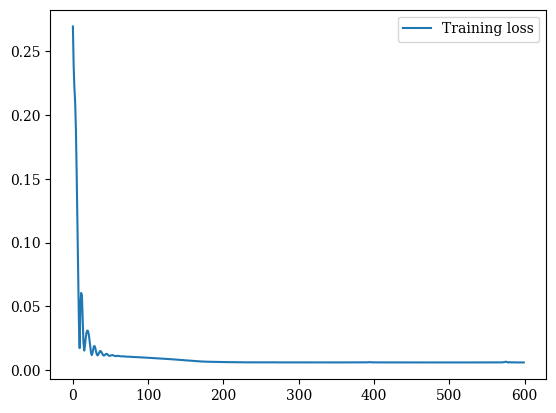

torch.Size([365, 1])

In [17]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()
np.shape(y_train_pred)

In [18]:
with torch.no_grad():
    y_train_pred = model(x_train)
    y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
testScore = math.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))

x_full = torch.cat((x_train, x_test), dim=0)  # Combine train and test data
with torch.no_grad():
    y_full_pred = model(x_full)

y_full_pred = scaler.inverse_transform(y_full_pred.detach().numpy())

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 2.73 RMSE
Test Score: 3.53 RMSE


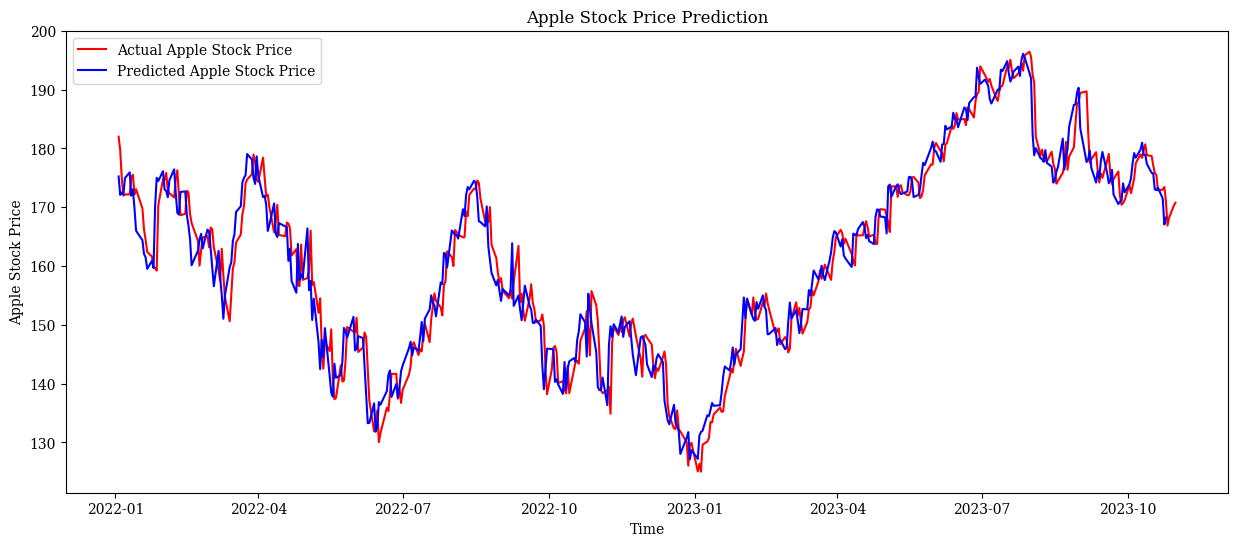

In [19]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_aapl.index, scaler.inverse_transform(df_aapl[['Close($)']]), color='red', label='Actual Apple Stock Price')
axes.plot(df_aapl.index[look_back:len(y_full_pred)+look_back], y_full_pred, color='blue', label='Predicted Apple Stock Price')

plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.savefig('AApred.png')
plt.show()